In [1]:
# LOAD DATA

import numpy as np
import torch
import torch.nn as nn
import torchinfo
import pathlib
import glob
import jnu as J
from tqdm.auto import tqdm
from torch.utils.data import TensorDataset, DataLoader

def dataset(name, rotation=False, batch_size=256, shuffle=True, threshold=1):
    PATH = pathlib.Path("./data/{0}.npz").resolve()
    data = np.load(str(PATH).format(name))
    rot = [data['z']] if rotation else []
    data = [data['x'], data['y'].astype(np.float32), *rot]
    
    if not rotation:
        data[1] = data[1].reshape(data[1].shape[0],-1).sum(-1) > threshold
        dataset = TensorDataset(*[torch.FloatTensor(x) for x in data])
        return DataLoader(dataset, batch_size=batch_size, drop_last=False, shuffle=shuffle)
    else:
        #print([d.shape for d in data])
        data[1] = data[1].reshape(data[1].shape[0],data[1].shape[1],-1).sum(-1) > threshold
        #print([d.shape for d in data])
        return [torch.FloatTensor(x) for x in data] # validation data use : zip(*val)

class Classifier(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3,8,7,2),nn.LeakyReLU(),
            nn.Conv2d(8,16,7,2), nn.LeakyReLU(),
            nn.Conv2d(16,32,7,2), nn.LeakyReLU())
        self.linear = nn.Sequential(
            nn.Linear(32*6*6, 1024),  nn.LeakyReLU(),
            nn.Linear(1024, 1024),    nn.LeakyReLU(),
            nn.Linear(1024, 1))
        
    def forward(self, x):
        z = self.conv(x)
        z = z.reshape(x.shape[0], -1)
        z = self.linear(z)
        return z
        


In [4]:
model = Classifier().cuda()
print(torchinfo.summary(model, input_size=(2,3,84,84)))
optim = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCEWithLogitsLoss()
t_loader = dataset("train")
v_loader = dataset("validate", rotation=True, shuffle=False)

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [2, 1]                    --
├─Sequential: 1-1                        [2, 32, 6, 6]             --
│    └─Conv2d: 2-1                       [2, 8, 39, 39]            1,184
│    └─LeakyReLU: 2-2                    [2, 8, 39, 39]            --
│    └─Conv2d: 2-3                       [2, 16, 17, 17]           6,288
│    └─LeakyReLU: 2-4                    [2, 16, 17, 17]           --
│    └─Conv2d: 2-5                       [2, 32, 6, 6]             25,120
│    └─LeakyReLU: 2-6                    [2, 32, 6, 6]             --
├─Sequential: 1-2                        [2, 1]                    --
│    └─Linear: 2-7                       [2, 1024]                 1,180,672
│    └─LeakyReLU: 2-8                    [2, 1024]                 --
│    └─Linear: 2-9                       [2, 1024]                 1,049,600
│    └─LeakyReLU: 2-10                   [2, 1024]           

In [9]:
pbar = tqdm(range(100))

def validate(model, v_loader):
    with torch.no_grad():
        losses = []
        for x, y_target, z in zip(*v_loader):
            y_pred = model(x.cuda()) 
            loss = criterion(y_pred.squeeze(), y_target.cuda()).cpu()
            losses.append(loss)
        return torch.stack(losses).mean()
            
for e in pbar:
    losses = []
    for x, y_target in t_loader:
        optim.zero_grad()
        y_pred = model(x.cuda())
        loss = criterion(y_pred.squeeze(), y_target.cuda())
        loss.backward()
        losses.append(loss.detach().cpu())
        optim.step()
        
    vloss = validate(model, v_loader)
    pbar.set_description(f"Train Loss: {torch.stack(losses).mean():.5f} Validate Loss: {vloss:.5f}")


  0%|          | 0/100 [00:00<?, ?it/s]

In [5]:
PATH = pathlib.Path("./MODEL-TEXTURE-CORRUPTION.pt").resolve()
#torch.save(model.state_dict(), str(PATH))
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [10]:
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.metrics import roc_curve, precision_recall_curve

model = model.cuda()
test_criterion = nn.BCEWithLogitsLoss(reduction="none")

def episode_score(x, y):
    with torch.no_grad():
        y_pred = model(x.cuda())
        y_target = y.numpy()
        y_pred = torch.sigmoid(y_pred).cpu().squeeze().numpy()
        return np.abs(y-y_pred), y_target
    
def plot(test, x, y, z, plot=True, return_invalid=False):
    with torch.no_grad():
        y_pred = model(x.cuda())
        y_target = y
        if not return_invalid and y_target.sum() == 0:
            return False, None, None
        y_pred = torch.sigmoid(y_pred).cpu().squeeze()

        m = 0.18
        n = 0.4
        #xz = np.cos(z * (np.pi/180))
        #yz = np.sin(z * (np.pi/180))
        xz = np.cos(z * 2*np.pi)
        yz = np.sin(z * 2*np.pi)

        xy = (n + y * m) * xz
        yy = (n + y * m) * yz

        xp = (n + y_pred * m) * xz
        yp = (n + y_pred * m) * yz

        e = np.abs(y-y_pred)
        xe = (m + e * m) * xz
        ye = (m + e * m) * yz

        #print("Error:", ((y_pred - y) ** 2).mean())
        #score0 = e[y == 0].sum() / (1-y).sum()
        #score1 = e[y == 1].sum() / y.sum()
        #print(f"{score0.item():.4f} & {score1.item() : .4f} & {score0.item() + score1.item() : .4f}\\\\")
        if plot:
            J.images(x, on_interact=y_pred, scale=3)
            fig = plt.figure(figsize=(4,4))
            plt.tick_params(top=False, bottom=False, left=False, right=False,
                    labelleft=False, labelbottom=False)
            plt.scatter(x=xp, y=yp, marker=".", color="black")
            plt.plot(xy, yy, color="black",zorder=0)
            norm = plt.Normalize(e.min(), e.max())
            plt.scatter(xe, ye, c=e, cmap='viridis', norm=norm, marker=".")
            plt.plot(xe, ye, zorder=0, color="black", alpha=0.1)   
        return True, e, y_target
    
def result(label, score, bug, log=True):  
    import sklearn.metrics as metrics
        
    fpr, tpr, thresholds = metrics.roc_curve(label, score)
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    
    pred = (score >= thresholds[ix]).astype(np.float32)
    report = metrics.classification_report(label, pred, target_names=["normal", "abnormal"], output_dict=True)

    (tn, fp, fn, tp) = metrics.confusion_matrix(label, pred).ravel()
    
    # create table of results
    empty = ''
    
    # PER CLASS STATISTICS
    iheader = f"Bug & Class & Precision  & Recall     & F1-score   & Support & True & False \\\\ \hline \n"
    # ("\multicolumn{5}{|c|}{" + bug_names[bug] + "} \\\\ \hline \n")\
    itable1 = f"{bug:20} & 0 (N) & {report['normal']['precision']:10.3f}   & {report['normal']['recall']:10.3f}   & {report['normal']['f1-score'] :10.3f}  & {report['normal']['support'] :10}  & {tn:10} & {fp:10}   \\\\ \n" #& {UDS(score[np.logical_not(label)]):10.3f} \\\\ \n"
    itable2 = f"{empty:20} & 1 (A) & {report['abnormal']['precision']:10.3f} & {report['abnormal']['recall']:10.3f} & {report['abnormal']['f1-score']:10.3f} & {report['abnormal']['support']:10} & {tp:10} & {fn:10} \\\\ \hline \n" #& {UDS(score[label]):10.3f} \\\\ \hline \n"
    itable = itable1 + itable2
    
    # CLASSIFICATION STATISTICS
    mheader = f"Bug & Threshold & G-Mean & PR AUC & PR NS & ROC AUC & Accuracy \\\\ \hline"
    mtable = f"{bug:4} & {thresholds[ix]:10.3f} & {gmeans[ix]:10.3f} & {metrics.average_precision_score(label, score):10.3f} & {(label.sum() / label.shape[0]):10.3f}  & {metrics.roc_auc_score(label, score) :10.3f} & {report['accuracy'] :10.3f} \\\\ \hline \n"
    
    print(iheader)
    print(itable)
    print(mheader)
    print(mtable)
    return iheader, itable, mheader, mtable

\begin{tabular}{|c|c|c|} \hline
\multicolumn{3}{|c|}{B1} \\ \hline
     & A. 1   & A. 0 \\ \hline
P. 1 & 7 & 1 \\
P. 0 & 3 & 9 \\ \hline
\end{tabular}
\begin{tabular}{|c|c|c|} \hline
\multicolumn{3}{|c|}{B2} \\ \hline
     & A. 1   & A. 0 \\ \hline
P. 1 & 10 & 0 \\
P. 0 & 0 & 10 \\ \hline
\end{tabular}
\begin{tabular}{|c|c|c|} \hline
\multicolumn{3}{|c|}{B3} \\ \hline
     & A. 1   & A. 0 \\ \hline
P. 1 & 10 & 5 \\
P. 0 & 0 & 5 \\ \hline
\end{tabular}
\begin{tabular}{|c|c|c|} \hline
\multicolumn{3}{|c|}{B4} \\ \hline
     & A. 1   & A. 0 \\ \hline
P. 1 & 10 & 0 \\
P. 0 & 0 & 10 \\ \hline
\end{tabular}
\begin{tabular}{|c|c|c|} \hline
\multicolumn{3}{|c|}{B5} \\ \hline
     & A. 1   & A. 0 \\ \hline
P. 1 & 8 & 1 \\
P. 0 & 2 & 9 \\ \hline
\end{tabular}


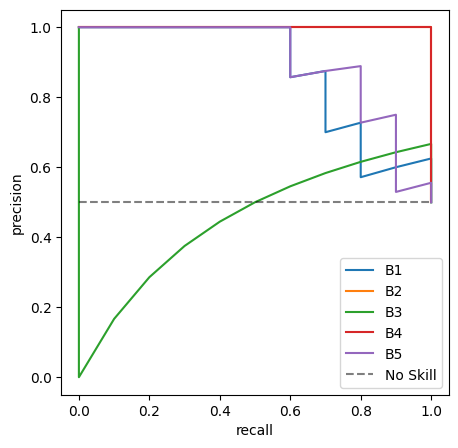

In [29]:
import sklearn.metrics as metrics
def plot_pr(score, label, legend=None):
    p, r, _ = precision_recall_curve(lael, score)
    plt.plot(r, p, label=legend)

def test_scores(test):
    t_loader = dataset(f"test/{test}", rotation=True, shuffle=False, threshold=100)
    scores, labels = [], []
    for i, (x, y, z) in enumerate(zip(*t_loader)):
        score, label = episode_score(x, y)
        avg_score = score.mean().item()
        avg_1_score = (score * label).mean().item()
        avg_0_score = (score * (1-label)).mean().item()
        label = float(label.sum() > 0)
        scores.append((avg_score, avg_0_score, avg_1_score)), labels.append(label)
    return scores, labels

def avg_training_score():
    t_loader = dataset(f"train/train", rotation=True, shuffle=False, threshold=100)
    scores = []
    for i, (x, y) in enumerate(zip(*t_loader)):
        score, _ = episode_score(x, y)
    return np.concatenate(scores).mean() # average training error


# \item (B1) Global illumination changed.
# \item (B2) Agent starting position changed.
# \item (B3) Corrupted texture failed to manifest at all.
# \item (B4) Texture corruption was not rendered in the mask. 
# \item (B5) A missing texture bug is also present in the episode.


TESTS = {"B1":"GlobalIllumination", "B2":"PositionChanged", "B3":"None", "B4":"MaskNotRendered", "B5":"TextureMissing"}




nscore, nlabel = test_scores("Normal")
ns, ns0, ns1 = zip(*nscore)

#training_score = avg_training_score()

fig_pr = plt.figure(figsize=(5,5))

for key, test in TESTS.items():
    score, label = test_scores(test)

    s, s0, s1 = zip(*score) 
    y, x = np.concatenate([np.zeros_like(nlabel),np.ones_like(label)]), np.concatenate([ns,s])
    p, r, _ = precision_recall_curve(y, x)
    plt.plot(r, p, label=f"{key}")
    
    fpr, tpr, thresholds = metrics.roc_curve(y, x)
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    pred = (x >= thresholds[ix]).astype(np.float32)
    (tn, fp, fn, tp) = metrics.confusion_matrix(y, pred).ravel()
    #print(y, pred)   
    print("\\begin{tabular}{|c|c|c|} \hline")
    print("\multicolumn{3}{|c|}{" + key + "} \\\\ \hline")
    print(f"     & A. 1   & A. 0 \\\\ \hline")
    print(f"P. 1 & {tp} & {fp} \\\\")
    print(f"P. 0 & {fn} & {tn} \\\\ \hline")
    print("\\end{tabular}")
    #x0 = np.concatenate([ns0,s0])
    #p, r, _ = precision_recall_curve(y, x0)
    #plt.plot(r, p, label=f"error(0)")
    #x1 = np.concatenate([ns1,s1])
    #p, r, _ = precision_recall_curve(y, x1)
    #plt.plot(r, p, label=f"error(1)")
    #p, r, _ = precision_recall_curve(y, x0+x1)
    #plt.plot(r, p, label=f"error(0+1)")
    
no_skill = len(y[y==1]) / len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill', color="black", alpha=0.5)
plt.gca().set_ylabel("precision")
plt.gca().set_xlabel("recall")
plt.legend()

plt.savefig("./pr-curve.png", bbox_inches="tight")




Normal
1 ------------


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=449), Output()), _do…

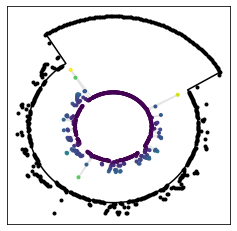

2 ------------


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=449), Output()), _do…

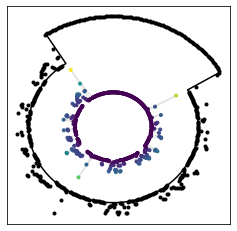

3 ------------


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=449), Output()), _do…

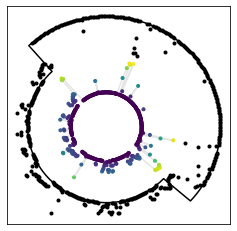

4 ------------


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=449), Output()), _do…

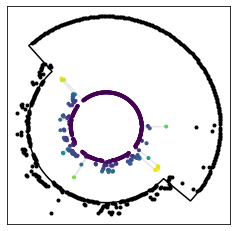

5 ------------


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=449), Output()), _do…

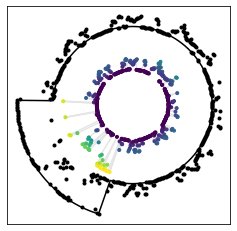

6 ------------


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=449), Output()), _do…

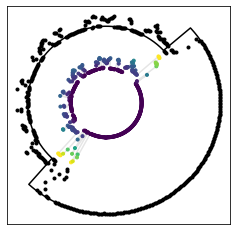

7 ------------


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=449), Output()), _do…

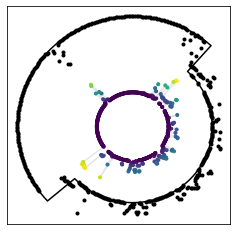

8 ------------


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=449), Output()), _do…

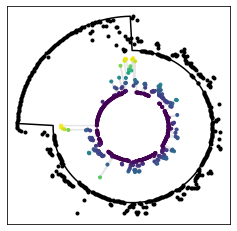

9 ------------


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=449), Output()), _do…

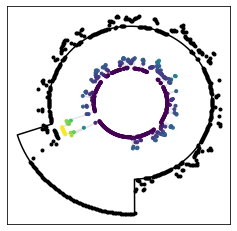

10 ------------


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=449), Output()), _do…

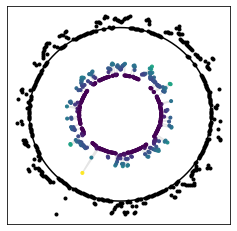

num_episodes = 10
imbalance = 0.31466665863990784
PositionChanged
1 ------------


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=449), Output()), _do…

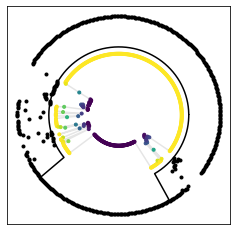

2 ------------


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=449), Output()), _do…

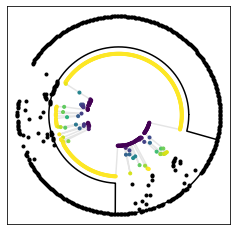

3 ------------


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=449), Output()), _do…

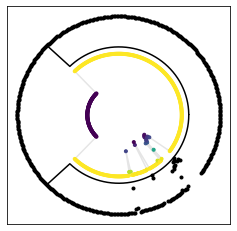

4 ------------


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=449), Output()), _do…

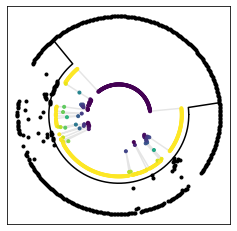

5 ------------


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=449), Output()), _do…

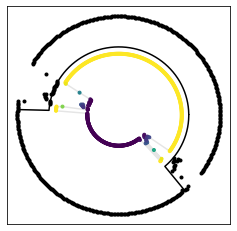

6 ------------


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=449), Output()), _do…

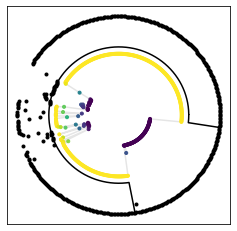

7 ------------


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=449), Output()), _do…

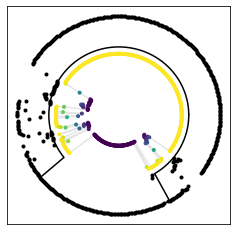

8 ------------


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=449), Output()), _do…

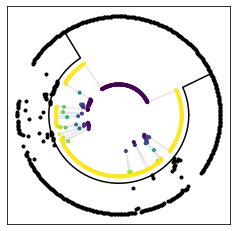

9 ------------


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=449), Output()), _do…

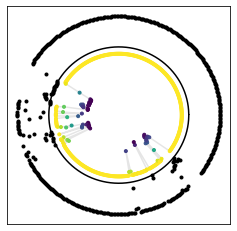

10 ------------


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=449), Output()), _do…

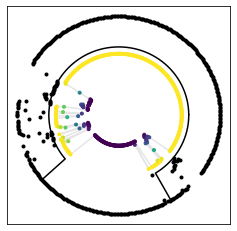

num_episodes = 10
imbalance = 0.23444443941116333
GlobalIllumination
1 ------------


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=449), Output()), _do…

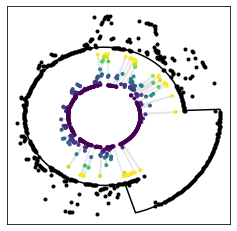

2 ------------


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=449), Output()), _do…

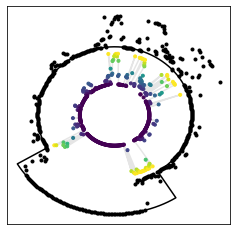

3 ------------


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=449), Output()), _do…

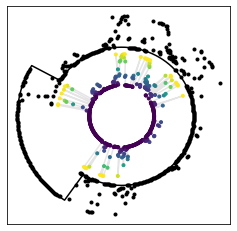

4 ------------


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=449), Output()), _do…

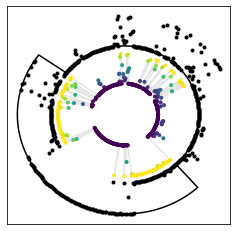

5 ------------


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=449), Output()), _do…

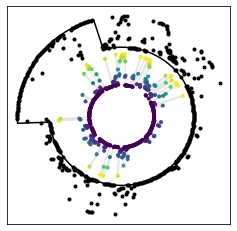

6 ------------


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=449), Output()), _do…

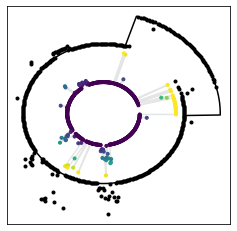

7 ------------


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=449), Output()), _do…

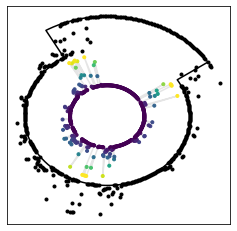

8 ------------


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=449), Output()), _do…

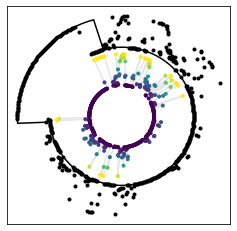

9 ------------


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=449), Output()), _do…

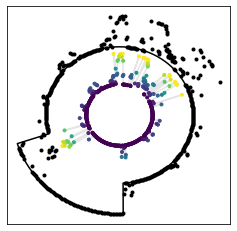

10 ------------


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=449), Output()), _do…

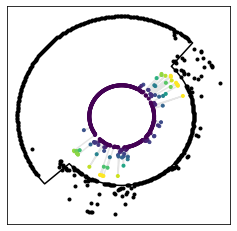

num_episodes = 10
imbalance = 0.2795555591583252
None
1 ------------


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=449), Output()), _do…

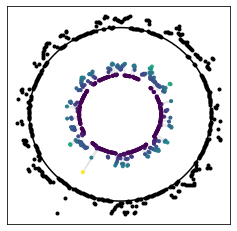

2 ------------


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=449), Output()), _do…

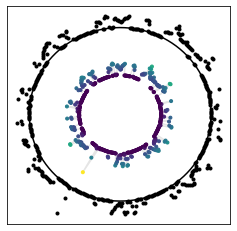

3 ------------


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=449), Output()), _do…

KeyboardInterrupt: 

In [9]:
# compute stats
TESTS = ["Normal", "PositionChanged", "GlobalIllumination", "None", "MaskNotRendered","TextureMissing"]

for test in TESTS:
    t_loader = dataset(f"test/{test}", rotation=True, shuffle=False, threshold=100)
    print(test)
    scores, labels = [], []
    for i, (x, y, z) in enumerate(zip(*t_loader)):
        print(i+1, "------------")
        valid, score, label = plot(test, x, y, z, plot=True, return_invalid=True)
        if not valid:
            continue
        #plt.savefig(f"./images/{test}-plot{i+1}.png", dpi=200, bbox_inches='tight', transparent=True, pad_inches=0)   
        plt.show()
        scores.append(score)
        labels.append(label)
        # compute some score statistics
    print(f"num_episodes = {len(scores)}")
    scores = torch.cat(scores)
    labels = torch.cat(labels)
    print(f"imbalance = {labels.sum() / labels.shape[0]}")
    #result(labels.numpy(), scores.numpy(), test)
    

In [ ]:

TESTS = ["Normal", "PositionChanged", "GlobalIllumination", "None", "MaskNotRendered","TextureMissing"]
for test in TESTS:
    t_loader = dataset(f"test/{test}/{test}", rotation=True, shuffle=False, threshold=200)
    print(test, "-----------------------------------")
    for i, (x, y, z) in enumerate(zip(*t_loader)):
        if plot(test, x, y, z):
            plt.show()
            break
            
    print("----------------------")

    
# Global illumination still does ok, maybe increase it? 

In [ ]:

        e = (e[:-1] + e[1:]) / 2
        points = np.array([xe.numpy(), ye.numpy()]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        # Create a continuous norm to map from data points to colors
        norm = plt.Normalize(e.min(), e.max())
        lc = LineCollection(segments, cmap='viridis', norm=norm)
        # Set the values used for colormapping
        lc.set_array(e)
        lc.set_linewidth(2)
        line = plt.gca().add_collection(lc)
        plt.gca().set_xlim(-1, 1)
        plt.gca().set_ylim(-1, 1)
        
        

In [ ]:
PATH = pathlib.Path("./World-v0-TextureCorruption").resolve()
FILES = glob.glob(str(PATH) + "/test/*-episode-*.tar.gz")
FILES = list(sorted(FILES, key=lambda x: int(x.split("/")[-1].split(".")[0].split("-")[-1])))
#print(FILES)

#test_dataset(FILES, name="test-bugged")

for file in FILES:
    print(file.split("/")[-1].split("-")[0])
